# Decision Tree Classifier

In [1]:
import pickle
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn import metrics
from sklearn import tree
import graphviz 

### Load data

In [2]:
df = pd.read_csv("../data/mixed_data_1200.csv", sep=';')
df = df.drop(["Unnamed: 0"],axis=1)
df.head(5)

,target,text
0,0,@Starrbby too bad I won't be around I lost my ...
1,0,amazon s3 plugin not worked in my website . it...
2,0,The Hoyts Distribution NZ website isn't workin...
3,0,dang won't be able to get to any workshops run...
4,0,Tried to install a Twitter-application on my p...


### Split data into train/test set

In [3]:
df.head(5)
#converts whitespaces
trb_nan_idx = df[pd.isnull(df['text'])].index.tolist()
df.loc[trb_nan_idx, 'text'] = ' '

In [4]:
df["target"].value_counts()

4    1186
2    1186
0    1186
Name: target, dtype: int64

In [5]:
duf = df.drop_duplicates(subset=['text'], keep="first")

In [6]:
#check the frequence of tweets, one means no dupplicates
max(duf["text"].value_counts())

1

In [7]:
X_load = duf["text"]
Y_load = duf["target"]

In [8]:
X_load.describe()

count                                                  3309
unique                                                 3309
top       Yay another art raffle! Everything you need to...
freq                                                      1
Name: text, dtype: object

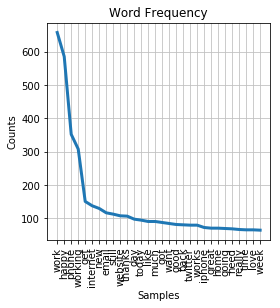

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist

stop_eng = stopwords.words('english')

tokens = []
sentences = []
for txt in X_load.values:
    sentences.append(str(txt).lower())
    tokens.extend([str(t).lower().strip(":,.!?") for t in str(txt).split()])

hashtags = [w for w in tokens if w.startswith('#')]
mentions = [w for w in tokens if w.startswith('@')]
links = [w for w in tokens if w.startswith('http') or w.startswith('www')]
filtered_tokens = [w for w in tokens \
                   if not w in stop_eng \
                   and w.isalpha() \
                   and not len(w)<3 \
                   and not w in hashtags \
                   and not w in links \
                   and not w in mentions]
freq_dist = nltk.FreqDist(filtered_tokens)
plt.figure(figsize=(4, 4))
freq_dist.plot(30,cumulative=False,title='Word Frequency',linewidth=3)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_load,Y_load,test_size=0.2,random_state=42,shuffle=True)

In [11]:
print(y_train.value_counts())

0    924
2    909
4    814
Name: target, dtype: int64


In [12]:
y_test.value_counts()

0    259
2    216
4    187
Name: target, dtype: int64

In [13]:
y_train_count = np.array(y_train.value_counts())
y_test_count = np.array(y_test.value_counts())

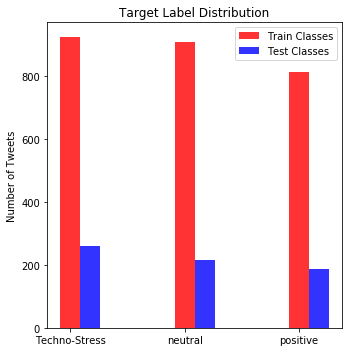

In [14]:
bar_width = 0.35
opacity = 0.8
plt.figure(figsize=(5,5))
rects1 = plt.bar([0.0,2.0,4.0], y_train_count,bar_width,alpha=opacity,color='r',label='Train Classes',align='center')
rects2 = plt.bar([0.35,2.35,4.35],y_test_count,bar_width,alpha=opacity,color='b',label='Test Classes',align='center')
plt.title("Target Label Distribution") 
LABELS = ["Techno-Stress", "neutral", "positive"]
plt.xticks([0,2,4], LABELS)
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.legend()
plt.show()

### Vectorize Data

In [15]:
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
X_test_counts = count_vect.transform(X_test.values.astype('U'))
X_train_counts.shape
#print(X_train_counts.toarray()[0])

(2647, 5970)

In [16]:
tokens = count_vect.get_feature_names()
print(len(tokens)) # number of tokens
#print(tokens)

5970


### TF-IDF Data

In [17]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_train_tfidf.shape

(2647, 5970)

### Train model

In [18]:
treeModel = DecisionTreeClassifier()
treeModel.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Predict
use the unlabled data

In [19]:
predictions = treeModel.predict(X_test_tfidf)

### Evaluate

In [20]:
np.mean(predictions == y_test) #accuracy

0.8806646525679759

In [21]:
print(metrics.classification_report(y_test, predictions,target_names=["techno-stress","neutral","positive"]))
report = metrics.classification_report(y_test, predictions,target_names=["techno-stress","neutral","positive"],output_dict=True)
reportdf = pd.DataFrame(report).transpose()
#print(reportdf.to_latex())


               precision    recall  f1-score   support

techno-stress       0.97      0.94      0.95       259
      neutral       0.83      0.90      0.86       216
     positive       0.83      0.78      0.80       187

    micro avg       0.88      0.88      0.88       662
    macro avg       0.87      0.87      0.87       662
 weighted avg       0.88      0.88      0.88       662



#### Learning Curve

/Users/ChrisChross/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


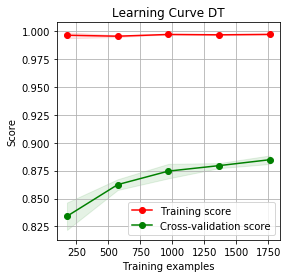

In [22]:
learn1 = skplt.estimators.plot_learning_curve(treeModel, X_train_tfidf, y_train,figsize=(4,4))
plt.title("Learning Curve DT")
plt.show()

#### Confusion Matrix

<Figure size 432x288 with 0 Axes>

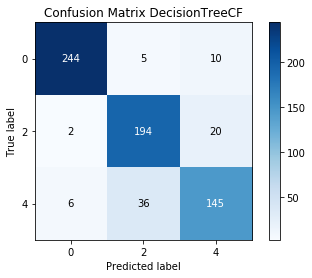

In [23]:
plt.figure()
skplt.metrics.plot_confusion_matrix(y_test,predictions,normalize=False)
plt.title("Confusion Matrix DecisionTreeCF")
plt.show()

#### Decision Tree  

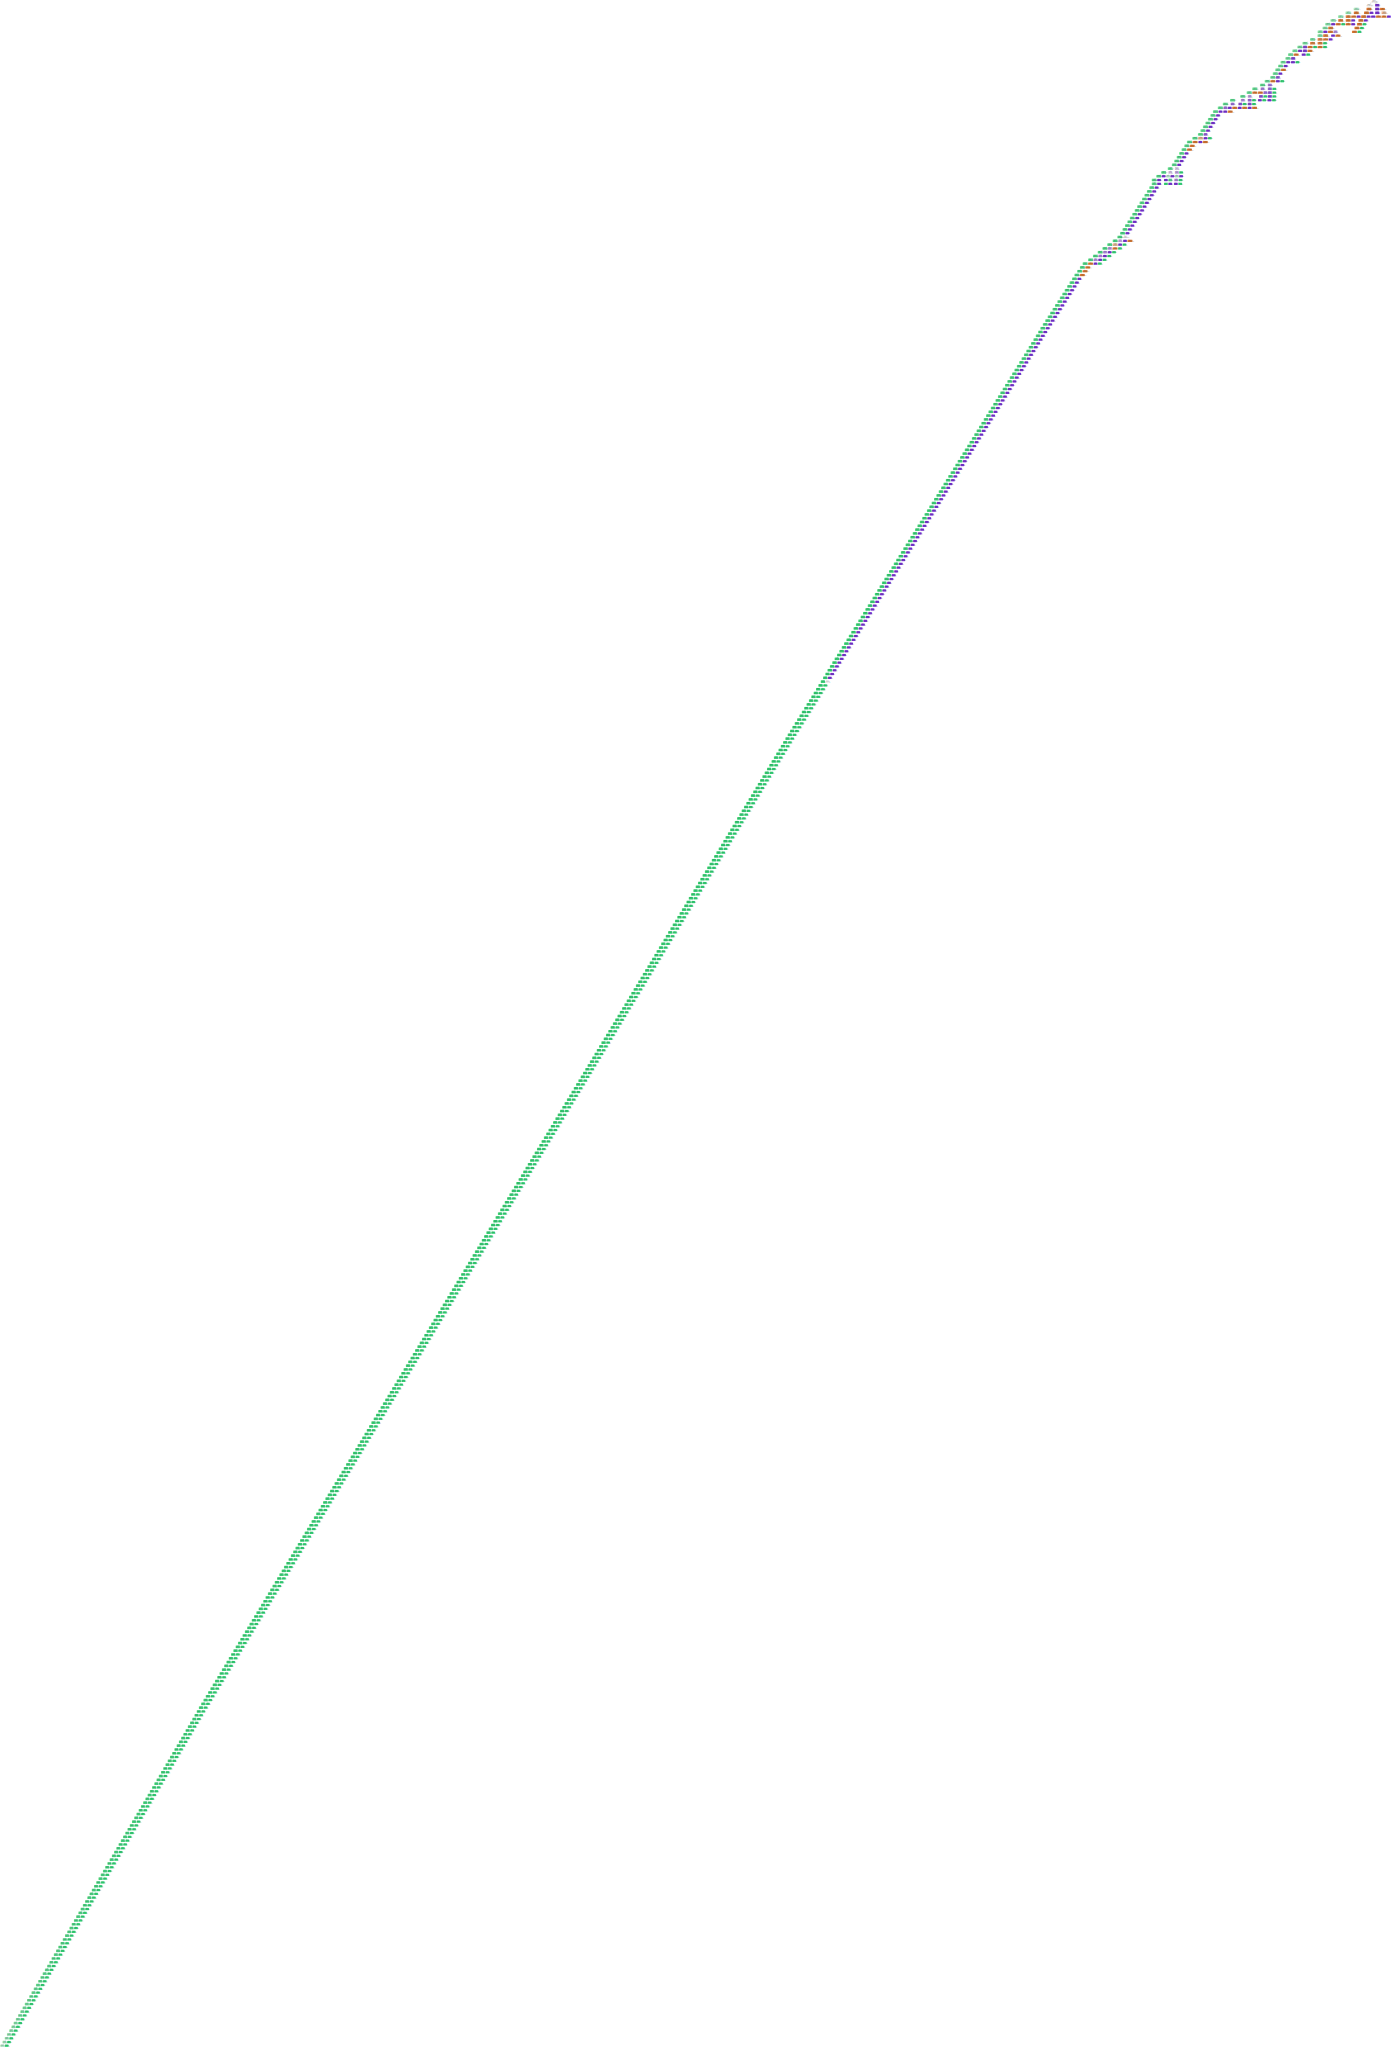

In [24]:
dot_data = tree.export_graphviz(treeModel, out_file=None,
                                class_names=["techno-stress","neutral","positive"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

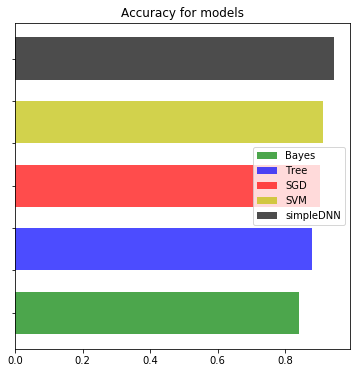

In [25]:
bayes = [0.8398791540785498] # 0.9044943820224719
tree = [0.877643504531722] # 0.8974719101123596
sgd = [0.9018126888217523] # 0.9199438202247191
svm = [0.9108761329305136] # 0.9339887640449438
simpleDNN = [0.9438202381134033]
bars = [0.84,0.88,0.90,0.91,0.94]
opacity = 0.7
#figure4 = plt.figure(figsize=(6,6))
fig4, ax = plt.subplots(figsize=(6,6))
rects1 = plt.barh([0.0],bayes,0.1,alpha=opacity,color='g',label='Bayes')
rects2 = plt.barh([0.15],tree,0.1,alpha=opacity,color='b',label='Tree')
rects3 = plt.barh([0.30], sgd,0.1,alpha=opacity,color='r',label='SGD')
rects4 = plt.barh([0.45], svm,0.1,alpha=opacity,color='y',label='SVM')
rects5 = plt.barh([0.60], simpleDNN,0.1,alpha=opacity,color='black',label='simpleDNN')
plt.title("Accuracy for models")
#plt.tight_layout()
ax.set_yticklabels([])
plt.legend()
plt.show()

In [28]:
data = {"model_name":["bayes","tree","sgd","svm","simpleDNN"],"accuracy":[0.84,0.88,0.90,0.91,0.94]}
ssdf = pd.DataFrame(data)
print(ssdf.to_latex())

\begin{tabular}{llr}
\toprule
{} & model\_name &  accuracy \\
\midrule
0 &      bayes &      0.84 \\
1 &       tree &      0.88 \\
2 &        sgd &      0.90 \\
3 &        svm &      0.91 \\
4 &  simpleDNN &      0.94 \\
\bottomrule
\end{tabular}

